# NGC2323 Data Processing Darks

**Import all important libraries**

In [1]:
import numpy as np
import pandas as pd
import astropy
import photutils
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc                               

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia


C:\Users\Msi Raider\AppData\Local\Temp\ipykernel_7804\21771852.py:13: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
C:\Users\Msi Raider\AppData\Local\Temp\ipykernel_7804\21771852.py:13: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
C:\Users\Msi Raider\AppData\Local\Temp\ipykernel_7804\21771852.py:13: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2d

The darks are put into a collection using the ccdproc

In [2]:
# Loading in the darks
images = ccdproc.ImageFileCollection(".",glob_include = 'Dark_*')
for fn in images.files_filtered(PICTTYPE = 3):
    print(fn)

darks = [CCDData.read(fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 3)]

Set OBSGEO-Y to  2879792.379 from OBSGEO-[LBH].
Set OBSGEO-Z to -3897419.410 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2879792.379 from OBSGEO-[LBH].
Set OBSGEO-Z to -3897419.410 from OBSGEO-[LBH]'.


Dark_3600.000secs_-20.11C_00002068.fit
Dark_3600.000secs_-20.11C_00002069.fit
Dark_3600.000secs_-20.11C_00002070.fit
Dark_3600.000secs_-20.11C_00002072.fit
Dark_3600.000secs_-20.11C_00002073.fit
Dark_3600.000secs_-20.11C_00002074.fit
Dark_3600.000secs_-20.20C_00002071.fit


The images are then loaded into a list where the values of the list correspond to the x and y pixels ADU value.

To check the darks were imported correctly, we print the minimum, maximum, mean and standard deviation of one of the dark images and we print out one of the dark images to double check.



Stats of Dark_3600.000secs_-20.11C_00002068.fit


Min: 805
Max: 65535
Mean: 2504.4666693596723
Stdev: 1042.4099312784913




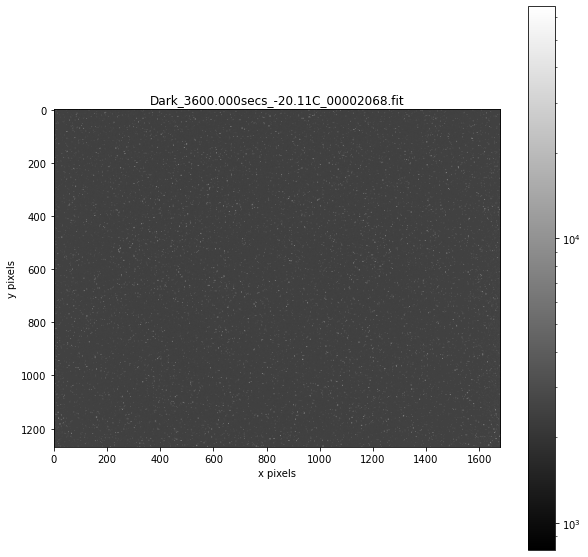

In [3]:
print('\n')
print('Stats of Dark_3600.000secs_-20.11C_00002068.fit')
print('\n')
print('Min:', np.min(darks[0]))
print('Max:',np.max(darks[0]))
print('Mean:',np.mean(darks[0]))
print('Stdev:',np.std(darks[0]))
print('\n')

plt.figure(figsize=(10,10))
plt.title('Dark_3600.000secs_-20.11C_00002068.fit')
plt.xlabel('x pixels')
plt.ylabel('y pixels')
plt.imshow(darks[0],cmap='gray', norm=LogNorm())
plt.colorbar()

Now that we know our data has been imported correctly, we can start manipulating our images. The first step is to subtract the median bias image from our darks. <br>

In [5]:
# Subtracting the bias from each of the dark frames

bias_median = CCDData.read('bias_median.fits', unit = "adu")
for idx, thisimage in enumerate(darks): 
    darks[idx] = ccdproc.subtract_bias(thisimage, bias_median) #subtracts the bias_median from each dark frame

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


We then perform a median combine of our dark images.

In [6]:
# Combining the darks into a simgle frame

dark_median = ccdproc.Combiner(darks, dtype=np.float32).median_combine()

To check that our combine has worked as intended, we print out some statistics and the median image.

Dark Median Combine Stats


Min: -1218.0
Max: 63532.5
Mean: 473.24362
Stdev: 1042.248291015625




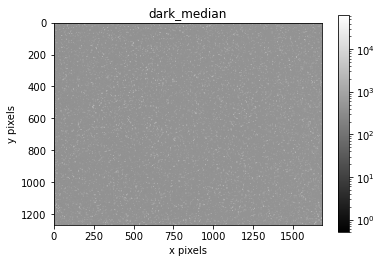

In [8]:
print('Dark Median Combine Stats')
print('\n')
print('Min:', np.min(dark_median))
print('Max:',np.max(dark_median))
print('Mean:',np.mean(dark_median))
print('Stdev:',np.std(dark_median))
print('\n')

plt.title('dark_median')
plt.xlabel('x pixels')
plt.ylabel('y pixels')
plt.imshow(dark_median,cmap='gray', norm=LogNorm())
plt.colorbar()

As the dark_median is currently stored in a variable, we update the objects headers and then write the data into a fits file labeled 'dark_median'.

In [9]:
# Updating the headers of the dark frames

dark_median.meta.update(EXPTIME = 3600)
dark_median.meta.update(TELESCOP = 'C14')
dark_median.meta.update(OBJECT = 'Dark_Median')
dark_median.write("dark_median.fits")